# I. Import neccessary libraries

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import json
import gzip
import time
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from langdetect import detect 

# gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter

# spaCy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# II. Import Data

The dataset used in this experiment came from the Musical Instrument category in the Amazon Review dataset and was saved in a JSON file. It contains 231,392 observations with relevant
details such as product information, images, review content, user ID, etc. Each entry is a review of a specific product. The data is extracted and stored in a DataFrame `df` along with its corresponding features.

In [2]:
def getDF(path):
    # Open the gzip file
    with gzip.open(path, 'rb') as f:
        # Load the JSON content from the file
        data = [json.loads(line) for line in f]

    # Convert the JSON content to a DataFrame
    return pd.DataFrame(data)

# File path
file_path = r"C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Dataset\Musical_Instruments_5.json.gz"

# Get the DataFrame
df = getDF(file_path)

In [3]:
print("Data shape:",df.shape)
df.head()

Data shape: (231392, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN


# III. Data Exploration.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231392 entries, 0 to 231391
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         231392 non-null  float64
 1   verified        231392 non-null  bool   
 2   reviewTime      231392 non-null  object 
 3   reviewerID      231392 non-null  object 
 4   asin            231392 non-null  object 
 5   reviewerName    231367 non-null  object 
 6   reviewText      231344 non-null  object 
 7   summary         231341 non-null  object 
 8   unixReviewTime  231392 non-null  int64  
 9   vote            34777 non-null   object 
 10  style           121310 non-null  object 
 11  image           3889 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 19.6+ MB


In [5]:
#check if there is any missing values
df.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          25
reviewText            48
summary               51
unixReviewTime         0
vote              196615
style             110082
image             227503
dtype: int64

Missing values (NaN) are found in several columns: reviewerName, reviewText, summary, vote, style, and images. To be precise, there are 25 missing values in reviewerName, 48 in reviewText, 51 in summary, 196,615 in vote, 110,082 in style, and 227,503 in image. Out of these numbers, only the missing values (empty string) in the reviewText column will severely impact the process of building a topic model. Besides, 48 out of 231,392 reviews is a relatively small percentage, therefore, these 48 reviews with missing text will be excluded from the dataset before building LDA models.

In [6]:
# Count number of users and products
unique_user_count = df['reviewerID'].nunique()
unique_verified_users_count = df[df['verified'] == True]['reviewerID'].nunique()
unique_unverified_users_count = df[df['verified'] == False]['reviewerID'].nunique()
unique_product_count = df['asin'].nunique()

# Display the counts
print(f"Number of total users: {unique_user_count}")
print(f"Number of verified users: {unique_verified_users_count}")
print(f"Number of unverified users: {unique_unverified_users_count}")
print(f"Number of products: {unique_product_count}")

Number of total users: 27530
Number of verified users: 27222
Number of unverified users: 9075
Number of products: 10620


There are 9,075 unverified users. As text bot and fake reviews are quite the issue in customer reviews, it is also advisable to remove these reviews to reduce the noise in the dataset.

In [7]:
# Function to detect different language in the review content
def detect_language(text):
    try:
        return detect (text)
    except:
        return 'Error'

In [8]:
df['language'] = df['reviewText'].apply(detect_language)
print(f'Display number of reviews in each language:')
print(df['language'].value_counts())

Display number of reviews in each language:
language
en       213976
af         3001
ro         2486
ca         1942
so         1687
de          923
fr          667
es          543
pl          499
no          497
sl          466
sk          452
cy          445
da          430
pt          381
it          345
et          320
hu          320
tl          297
nl          226
sv          224
vi          190
cs          169
sq          142
fi          141
id          137
hr          136
Error       132
tr          106
sw           66
lv           32
lt           14
Name: count, dtype: int64


This dataset contains customer reviews written in different languages,  indicating a broad international user base. While the predominant language is English with 213,976 reviews, 30 other identified languages make significant contributions to this dataset, such as Afrikaans (3,001 reviews), Romanian (2,486 reviews), and Catalan (1,942 reviews), Somali (1,687 reviews), German (923 reviews), and French (667 reviews).  Besides, the 'Error' category with 132 entries suggests potential issues in language detection or data collection that might need attention. 

Maximum Word Count: 4069
Minimum Word Count: 1
Average Word Count: 56.72814531185175


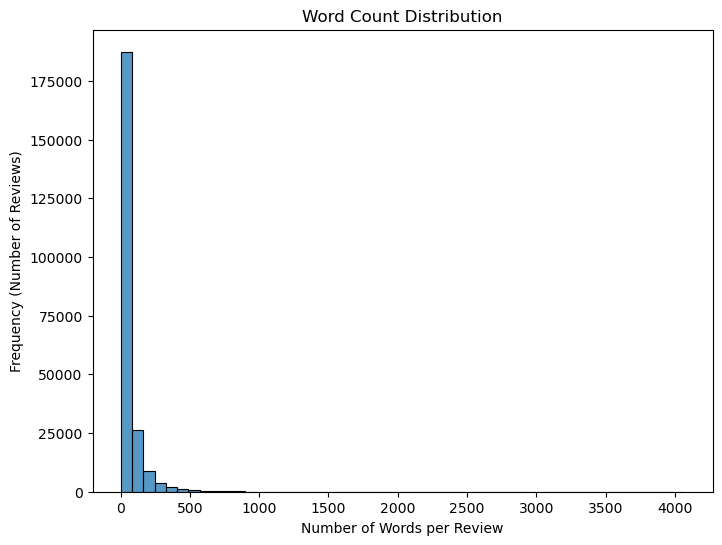

In [9]:
# Calculate max, min, and average word count
word_counts = df['reviewText'].apply(lambda x: len(str(x).split()))
max_word_count = word_counts.max()
min_word_count = word_counts.min()
avg_word_count = word_counts.mean()

# Display the calculated values
print(f"Maximum Word Count: {max_word_count}")
print(f"Minimum Word Count: {min_word_count}")
print(f"Average Word Count: {avg_word_count}")

# Plot the word count distribution
plt.figure(figsize=(8, 6))
sns.histplot(word_counts, bins=50)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency (Number of Reviews)")
plt.show()

This dataset has a mixture of both long text and short text with an average review length of 57 words. while the longest review consists of 4,069 words whilst the shortest review has none to one word. The word count distribution clearly shows that most of them are short text with less than 200 words.

In [10]:
# Calculate the distribution of product ratings
distribution = df['overall'].value_counts()
distribution

overall
5.0    161837
4.0     38783
3.0     16030
1.0      7465
2.0      7277
Name: count, dtype: int64

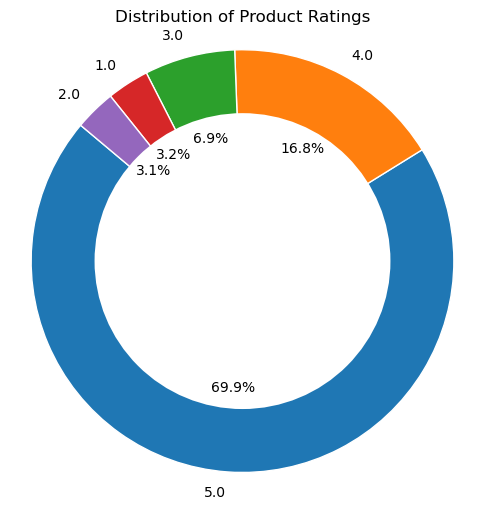

In [11]:
# Create a pie chart for the distribution of product ratings
plt.figure(figsize=(6, 6))
plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title('Distribution of Product Ratings')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Add a white circle in the center for the donut effect
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The product rating ranges from 1.0 being the lowest to 5.0 being the highest. Looking at the product rating this donut chart, most of them have 5.0 and 4.0, accounting for 86.7 % of the overall reviews whereas 1.0 and 2.0 ratings only make up for a little more than 6% of all reviews. This indicates that the customers are quite satisfied with their purchase in general. This information will become useful later when doing a more in-depth analysis of which features or areas need improvement or continuing development after the topic modeling is complete.

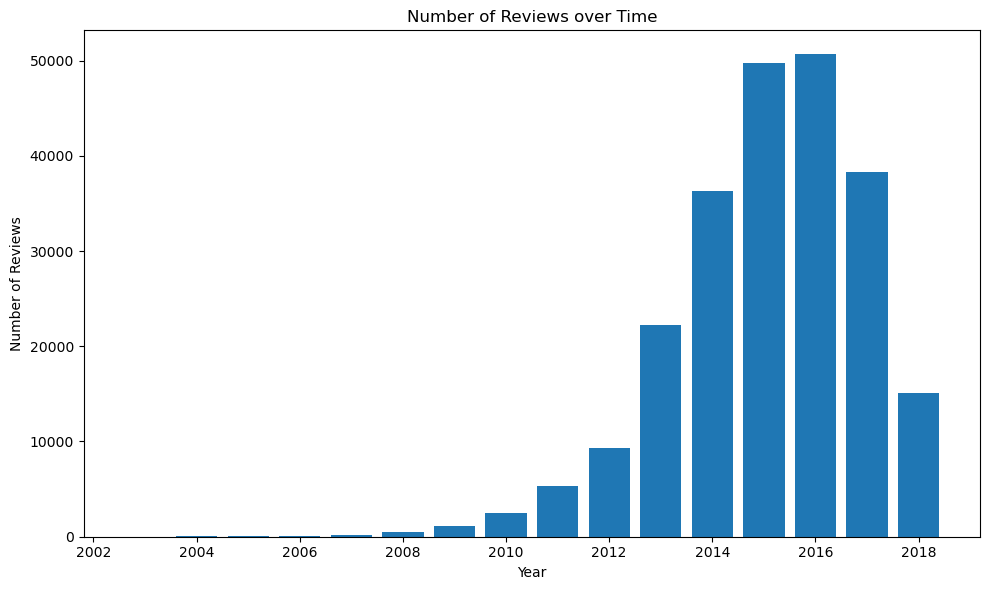

In [12]:
# Convert 'reviewTime' to a pandas datetime object
df['ReviewDate'] = pd.to_datetime(df['reviewTime'])

# Extract the year from the 'ReviewDate' column without adding it to the DataFrame
years = df['ReviewDate'].dt.year

# Count the number of reviews in each year
review_counts = years.value_counts().reset_index()
review_counts.columns = ['year', 'review_count']

# Sort the DataFrame by year
review_counts = review_counts.sort_values('year')

# Plot the number of reviews by year
plt.figure(figsize=(10, 6))
plt.bar(review_counts['year'], review_counts['review_count'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews over Time')
plt.tight_layout()
plt.show()

In [13]:
# Extract unique years
unique_years = df['ReviewDate'].dt.year.unique()

# Create a dictionary to store the months for each year
year_month_dict = {}

# Iterate through unique years and store the unique months for each year
for year in unique_years:
    months_in_year = df[df['ReviewDate'].dt.year == year]['ReviewDate'].dt.month.unique()
    year_month_dict[year] = sorted(months_in_year)  # Sort the months in ascending order

# Sort the years with missing months in ascending order
years_with_missing_months = sorted([year for year in year_month_dict.keys() if len(year_month_dict[year]) != 12])

# Print the sorted months missing in each year
for year in years_with_missing_months:
    missing_months = [month for month in range(1, 13) if month not in year_month_dict[year]]
    print(f"Year {year} is missing the following months: {missing_months}")

Year 2003 is missing the following months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
Year 2004 is missing the following months: [1, 2, 4, 5]
Year 2005 is missing the following months: [5, 7]
Year 2018 is missing the following months: [10, 11, 12]


The reviews were collected from October 2003 to September 2018 with most of them occurring between 2013 and 2017. There is missing data from the early years 2003, 2004, 2005, and later
year 2018. More specifically, the missing data is in November 2003, December 2003, January 2004, February 2004, April 2004, May 2004, May 2005, and July 2005. Normally, in other
analytical models, these missing values would be removed or replaced with appropriate values before the model development phase. However, in the case of topic modeling, the main factor
that affects the outcome of a topic model is the textual data. Because the missing dates do not affect the development of a topic model, there is no need to eliminate or substitute them.
However, it is essential to keep this in mind to come back and further look into this issue once the topics are defined.

# IV. Data Preprocessing

The preprocessing pipeline is mentioned below:

1.  Remove reviews that have missing text
2.  Remove duplicate reviews
3.  Remove reviews from unverified users
4.  Tokenize each review (using Gensim)
5.  Remove stop words (including punctuations)
6.  Lemmatize (using spaCy)
7.  Create dictionary and corpus

Lemmatization uses POS tags of words, therefore, we need to specify a list of POS tags ['NOUN', 'ADJ', 'VERB', 'ADV'] in this case.


## 1. Check and remove reviews with missing text
There are 48 entries with missing review text in the reviewText column. They will severely impact the process of building a topic model. As 48 out of 231,392 reviews is a relatively small percentage, they will be excluded from the dataset before building LDA model. The original dataset is reduced to 231,344 entries.

In [14]:
# Identifying rows where 'reviewText' is missing
missing_review_text_rows = df[df['reviewText'].isna()]

# Displaying the number of rows with missing 'reviewText'
num_missing_reviews = missing_review_text_rows.shape[0]
print(f"Number of reviews with missing text: {num_missing_reviews}")

# Optionally, to display the rows with missing 'reviewText'
if num_missing_reviews > 0:
    print("Reviews with missing text:")
    display(missing_review_text_rows.head())

Number of reviews with missing text: 48
Reviews with missing text:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,language,ReviewDate
16840,5.0,True,"01 25, 2018",A3N0SYVG1A2T5Y,B0002E1NNC,Robert h.,NaN,Five Stars,1516838400,NaN,"{'Size:': ' HD Light (.013-.053)', 'Style:': '...",NaN,Error,2018-01-25
16999,5.0,True,"11 18, 2017",A2ACJCJOSZOW8Z,B0002E1NNC,Private,NaN,Excellent Strings!,1510963200,NaN,"{'Size:': ' Light (.012-.053)', 'Style:': ' 80...",NaN,Error,2017-11-18
17465,5.0,True,"01 25, 2018",A3N0SYVG1A2T5Y,B0002E1NWI,Robert h.,NaN,Five Stars,1516838400,NaN,NaN,NaN,Error,2018-01-25
17627,5.0,True,"11 18, 2017",A2ACJCJOSZOW8Z,B0002E1NWI,Private,NaN,Excellent Strings!,1510963200,NaN,NaN,NaN,Error,2017-11-18
25914,5.0,True,"02 29, 2016",A2TB3K1Z2YG1O4,B0002E3CK4,Kelly,NaN,Five Stars,1456704000,NaN,"{'Size:': ' Regular Light, 10-46', 'Style:': '...",NaN,Error,2016-02-29


In [15]:
# Removing rows where 'reviewText' is missing
df = df.dropna(subset=['reviewText'])

# Optionally, to check the new size of the DataFrame after rows are removed
print(f"DataFrame size after removing rows with missing 'reviewText': {df.shape}")
df

DataFrame size after removing rows with missing 'reviewText': (231344, 14)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,language,ReviewDate
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN,en,2016-10-30
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN,en,2016-06-30
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN,en,2016-05-09
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN,en,2016-04-10
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN,en,2016-02-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231387,5.0,True,"03 29, 2018",A2GLR2Q3M1PC7P,B01HIDOPP2,nic field,It's pretty great.,Five Stars,1522281600,NaN,NaN,NaN,en,2018-03-29
231388,5.0,True,"11 18, 2017",A3S1LSTRW57BP9,B01HIDOPP2,2gene,Good inexpensive wiring harness. It will do th...,Five Stars,1510963200,NaN,NaN,NaN,en,2017-11-18
231389,4.0,True,"06 5, 2017",A2BNWRRADDBSVO,B01HIDOPP2,Tim,Easily installed and worked as expected.,Four Stars,1496620800,NaN,NaN,NaN,en,2017-06-05
231390,1.0,True,"05 27, 2017",A1KRL5ZRON6DPT,B01HIDOPP2,Jude the Obscure,The description stated they were full size pot...,Not as described.,1495843200,NaN,NaN,NaN,en,2017-05-27


## 2. Check and remove duplicated reviews for the same product from the same customer
Subsequently, an additional 18,571 duplicates are discarded since they do not have any significant information for the topic modeling process. This step substantially reduces the amount of reviews in the dataset to 221,955 entries.

In [16]:
# Identify rows with duplicated 'reviewerID','asin',and 'reviewText'
duplicated_review_text = df[df.duplicated(subset=['reviewerID','asin','reviewText'], keep=False)]

# Sort the DataFrame by 'reviewText' to group duplicates together
sorted_duplicated_reviews = duplicated_review_text.sort_values(by='reviewText')

# Displaythe number of rows with duplicated 'reviewText'
num_duplicated_reviews = sorted_duplicated_reviews.shape[0]
print(f"Number of rows with duplicated 'reviewText': {num_duplicated_reviews}")

# Display the sorted duplicated review text rows
if num_duplicated_reviews > 0:
    print("Sorted Duplicated 'reviewText' Rows:")
    display(sorted_duplicated_reviews.head(50))  # Displaying first 50 for brevity

Number of rows with duplicated 'reviewText': 18571
Sorted Duplicated 'reviewText' Rows:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,language,ReviewDate
80075,5.0,True,"06 7, 2014",A29YV7R4QB2V64,B000VO1EA0,Hunter,!!!!UPDATE!!!!\nSince people like to try to be...,I love it!!! Jimmy Page Dazed and Confused!,1402099200,3,{'Style:': ' Brazilwood'},[https://images-na.ssl-images-amazon.com/image...,en,2014-06-07
88841,5.0,True,"06 7, 2014",A29YV7R4QB2V64,B000VO1EA0,Hunter,!!!!UPDATE!!!!\nSince people like to try to be...,I love it!!! Jimmy Page Dazed and Confused!,1402099200,3,{'Style:': ' Brazilwood'},[https://images-na.ssl-images-amazon.com/image...,en,2014-06-07
85146,5.0,True,"02 13, 2015",A38Q3KGB8PB0UI,B00135HFK4,Randy Fine,#1,Five Stars,1423785600,NaN,{'Size:': ' SINGLE'},NaN,Error,2015-02-13
93912,5.0,True,"02 13, 2015",A38Q3KGB8PB0UI,B00135HFK4,Randy Fine,#1,Five Stars,1423785600,NaN,{'Size:': ' SINGLE'},NaN,Error,2015-02-13
84544,1.0,True,"02 25, 2012",A333OWA198OUIA,B0011FORIE,Burkhard Kefes,(Very poor quality. You can not really tune it...,not tuneable,1330128000,NaN,NaN,NaN,en,2012-02-25
93310,1.0,True,"02 25, 2012",A333OWA198OUIA,B0011FORIE,Burkhard Kefes,(Very poor quality. You can not really tune it...,not tuneable,1330128000,NaN,NaN,NaN,en,2012-02-25
88708,4.0,True,"10 26, 2013",A3NKYJCQBSA4LU,B000VJJQUU,Kamel,***UPDATE***\nThis cord has unexpectedly faile...,Better of the two budget XLR cords,1382745600,7,{'Size:': ' 1-Pack'},NaN,en,2013-10-26
79942,4.0,True,"10 26, 2013",A3NKYJCQBSA4LU,B000VJJQUU,Kamel,***UPDATE***\nThis cord has unexpectedly faile...,Better of the two budget XLR cords,1382745600,7,{'Size:': ' 1-Pack'},NaN,en,2013-10-26
81949,4.0,True,"09 12, 2010",A1GM034H7XPDEW,B000XPPR2S,Hurley,**So after reading a couple comments on this r...,not nearly long enough (for large body guitars),1284249600,2,{'Color:': ' Black'},NaN,en,2010-09-12
90715,4.0,True,"09 12, 2010",A1GM034H7XPDEW,B000XPPR2S,Hurley,**So after reading a couple comments on this r...,not nearly long enough (for large body guitars),1284249600,2,{'Color:': ' Black'},NaN,en,2010-09-12


In [17]:
# Remove duplicate rows based on selected columns
# keep='first' keeps the first occurrence and removes subsequent duplicates
df = df.drop_duplicates(subset=['reviewerID','asin','reviewText'], keep='first')

# Print the new size of the DataFrame after duplicates are removed
print(f"DataFrame size after removing duplicated reviews: {df.shape}")

DataFrame size after removing duplicated reviews: (221955, 14)


## 3. Check and remove reviews from unverified users
The next cleaning measure involves excluding the reviews from unverified users due to their potential to compromise the model's reliability by introducing inauthentic reviews from unverified sources, which may be generated by automated bots. From the dataset, a total of 23,015 reviews from 9,075 unverified users were removed. The remaining dataset has 198,940 reviews in total.

In [18]:
# check how many reviews are from verified users
df.value_counts('verified')

verified
True     198940
False     23015
Name: count, dtype: int64

In [19]:
# Removing unverified entries
df = df[df['verified'] == True]

# Print the new size of the DataFrame after removing reviews from unverified users
print(f"DataFrame size after removing removing reviews from unverified users: {df.shape}")

DataFrame size after removing removing reviews from unverified users: (198940, 14)


## 4. Tokenize each review (using Gensim)
Next, the tokenization process uses the ‘simple_preprocess’ method from the Gensim library to tokenize the review content. This method processes each review, converting them into lists of words and removing punctuation. By iterating over each review in the dataset and applying this method, the raw review texts are transformed into a format that is better suited for an NLP task. The result is a list of lists, where each sub-list contains the tokenized words of a corresponding review.

In [20]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))


# convert to list
data = df['reviewText'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[1])

['recommend', 'this', 'starter', 'ukulele', 'kit', 'has', 'everything', 'you', 'need', 'to', 'learn', 'the', 'ukulele']


## 5. Remove stop words (including punctuations)

Following that is the removal of stop words from the tokenized reviews. Stop words are frequently encountered words in a language that are generally considered irrelevant for data
analysis, such as "the", "is", "in". The elimination of stop words involves using a pre-defined list of standard English stop words from the Natural Language Toolkit (NLTK) library for Python. This list is further extended by including the set of punctuation marks. 

Afterward, a function is constructed to filter out these stop words from the list of tokenized words that are previously obtained from the reviews. This function iterates over each review in the dataset and removes words that appear in the stop words list. The result is a sublist of the tokenization list above, where the filtered tokens now contain no stop words and punctuations.

In [21]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
nltk.download('stopwords')
stop_words = stopwords.words('english') + list(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QuynhDinhHaiPham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
print('list of stop words:\n',stop_words)

list of stop words:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 's

In [23]:
# create a functions for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [24]:
# remove stop words
data_words_nostops = remove_stopwords(data_words)

In [25]:
print(data_words_nostops[3])

['according', 'order', 'history', 'bought', 'kit', 'towards', 'end', 'black', 'friday', 'week', 'lightning', 'deal', 'writing', 'nearly', 'four', 'years', 'later', 'stringed', 'instrument', 'strings', 'really', 'needed', 'stretch', 'would', 'stay', 'tune', 'first', 'several', 'days', 'play', 'minutes', 'tune', 'play', 'minutes', 'tune', 'tuning', 'daily', 'weeks', 'uke', 'held', 'tune', 'great', 'tuner', 'included', 'package', 'bulk', 'minus', 'star', 'real', 'beginner', 'way', 'tune', 'thing', 'need', 'either', 'tuner', 'reference', 'note', 'say', 'piano', 'keyboard', 'download', 'decent', 'tuner', 'app', 'though', 'buck', 'going', 'need', 'lot', 'first', 'couple', 'weeks', 'firebrand', 'ukulele', 'laminated', 'instrument', 'unknown', 'wood', 'kind', 'dead', 'sounding', 'soprano', 'ukes', 'generally', 'sound', 'bit', 'flattish', 'part', 'distinctive', 'character', 'finish', 'smooth', 'spotty', 'decal', 'around', 'sound', 'hole', 'bubbles', 'fretboard', 'barely', 'adequately', 'finishe

## 5. Lemmatize (using spaCy)

The text preprocessing continues with lemmatization – a process that transforms words to their base or dictionary form, known as lemmas. Utilizing the spaCy library in Python, a
lemmatization function was defined to process the previously filtered tokens. This function only takes into account words that are nouns, adjectives, verbs, or adverbs, since they greatly contribute to the semantic structure necessary for topic modeling. Upon the completion of the lemmatization process, the outcome is a list of lists where each sublist contains the lemmatized tokens.

In [26]:
# create a functions for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# initialize spacy 'en' model, use only tagger since we don't need parsing or NER
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Start the timer
start_time = time.time()

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# End the timer
end_time = time.time()

# Calculate the duration in seconds
duration_seconds = end_time - start_time

# Convert the duration to hours, minutes, and seconds
hours = int(duration_seconds // 3600)
minutes = int((duration_seconds % 3600) // 60)
seconds = int(duration_seconds % 60)

print("Execution time: ",hours,"hour(s) ",minutes," minute(s)",seconds," second(s)")
print(data_lemmatized[3])

Execution time:  0 hour(s)  14  minute(s) 7  second(s)
['accord', 'order', 'history', 'buy', 'kit', 'end', 'black', 'week', 'lightning', 'deal', 'write', 'nearly', 'year', 'later', 'string', 'instrument', 'string', 'really', 'need', 'stretch', 'stay', 'tune', 'first', 'several', 'day', 'play', 'minute', 'tune', 'play', 'minute', 'tune', 'tune', 'daily', 'week', 'uke', 'hold', 'tune', 'great', 'tuner', 'include', 'package', 'real', 'beginner', 'way', 'tune', 'thing', 'need', 'tuner', 'reference', 'note', 'say', 'piano', 'keyboard', 'download', 'decent', 'tuner', 'buck', 'go', 'need', 'lot', 'first', 'couple', 'week', 'firebrand', 'laminate', 'instrument', 'unknown', 'wood', 'kind', 'dead', 'sound', 'soprano', 'uke', 'generally', 'sound', 'bit', 'flattish', 'part', 'distinctive', 'character', 'finish', 'smooth', 'spotty', 'decal', 'sound', 'hole', 'bubble', 'fretboard', 'barely', 'adequately', 'finish', 'fret', 'nicely', 'flush', 'edge', 'neck', 'feel', 'smooth', 'stay', 'smooth', 'tempe

In [28]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker;
print(df.reviewText[3], '\n')
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

According to my order history, I bought this this kit towards the end of 2012 as a Black Friday Week Lightning Deal. I'm writing this nearly four years later.

As with any stringed instrument, the strings really needed to stretch out before they would stay in tune. So, for the first several days, it was play a few minutes, tune, play a few minutes, tune. Then it was tuning daily. After a few weeks of this, the uke held a tune great. A tuner is not included in the package, which is the bulk of the minus star because a real beginner wouldn't have a way to tune the thing. (You need either a tuner or a reference note, say, on a piano or keyboard.) You can download a decent tuner app, though, for a buck or so. Do it, because you're going to need it a lot for the first couple of weeks.

The "Firebrand" ukulele is a laminated instrument of unknown wood. It's kind of dead-sounding. But then, soprano ukes generally sound a bit flattish to me - it's part of their distinctive character. The finis

## 6. Creating dictionary and corpus

Once the lemmatization process is done, the next step involves constructing a dictionary and corpus that are necessary for LDA. The Gensim library offers the ‘corpora.Dictionary’ function, which assigns each unique lemmatized word to a specific integer ID, to help with the creation of a dictionary. This procedure is applied to the lemmatized data, resulting in an indexed dictionary. Afterward, a corpus is generated, which consists of a list of bags-of-words (BoW) representations of each document. It converts each document into a combination of word IDs and their corresponding frequencies. 

This concludes the data preprocessing steps for LDA, setting a foundation for the next model development phase.

In [55]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[3])

[(0, 2), (1, 5), (3, 5), (5, 3), (9, 10), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 5), (36, 2), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 2), (43, 1), (44, 3), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 2), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 3), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 2), (82, 2), (83, 2), (84, 3), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 5), (93, 1), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 6), (100, 1), (101, 2), (102, 1), (103, 2), (104, 1), (105, 2), (106, 1), (107, 1), (108, 3), (109, 1), (110, 1), (111, 1), (112, 1), (113, 2), (114, 1), (115, 1), (116, 

The (0, 2) above represents the fact that the word with id=0 appears 2 times in the 3rd review. Word id 1 appears 5 times and so on. The nested list below shows the frequencies of words in the first 3 reviews.

In [56]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[3:4]]

[[('beginner', 2),
  ('good', 5),
  ('need', 5),
  ('starter', 3),
  ('play', 10),
  ('year', 2),
  ('abrasive', 1),
  ('acceptable', 1),
  ('accord', 1),
  ('action', 2),
  ('add', 2),
  ('adequately', 1),
  ('adjustment', 1),
  ('advantage', 1),
  ('ago', 1),
  ('almost', 1),
  ('also', 2),
  ('angle', 1),
  ('available', 1),
  ('back', 1),
  ('bag', 1),
  ('barely', 1),
  ('bargain', 1),
  ('bevel', 1),
  ('binge', 1),
  ('bit', 2),
  ('black', 1),
  ('body', 1),
  ('book', 5),
  ('bridge', 2),
  ('bubble', 1),
  ('buck', 1),
  ('budget', 1),
  ('buy', 2),
  ('campfire', 1),
  ('carry', 2),
  ('catch', 1),
  ('change', 3),
  ('chapter', 1),
  ('character', 1),
  ('chord', 2),
  ('considerable', 1),
  ('consist', 1),
  ('cost', 2),
  ('couple', 2),
  ('daily', 1),
  ('day', 2),
  ('dead', 1),
  ('deal', 2),
  ('decal', 1),
  ('decent', 1),
  ('deeply', 1),
  ('definite', 1),
  ('diagram', 1),
  ('difference', 1),
  ('disadvantage', 1),
  ('discount', 1),
  ('distinctive', 1),
  ('dot

# V. Building LDA Topic Model

Let's now build the topic model. We'll define 10 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic (theta) distributions, whose default value is 1. Similarly, the hyperparameter beta `eta` can also be specified, which affects the topic-word distribution's sparsity.


In [31]:
# Start the timer
start_time = time.time()

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# End the timer
end_time = time.time()

# Calculate the duration in seconds
duration_seconds = end_time - start_time

# Convert the duration to hours, minutes, and seconds
hours = int(duration_seconds // 3600)
minutes = int((duration_seconds % 3600) // 60)
seconds = int(duration_seconds % 60)

print('Successfully build a LDA model with 10 topics! \n')
print("Execution time: ",hours,"hour(s) ",minutes," minute(s)",seconds," second(s)")

Successfully build a LDA model with 10 topics! 

Execution time:  0 hour(s)  24  minute(s) 5  second(s)


Let's now print the topics found in the dataset.

In [32]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"fine" + 0.073*"pickup" + 0.068*"build" + 0.048*"control" + '
  '0.032*"compare" + 0.023*"package" + 0.023*"people" + 0.021*"inexpensive" + '
  '0.018*"function" + 0.018*"prefer"'),
 (1,
  '0.055*"tone" + 0.036*"neck" + 0.029*"different" + 0.028*"fret" + '
  '0.025*"clean" + 0.020*"bridge" + 0.018*"adjust" + 0.018*"note" + '
  '0.017*"pot" + 0.015*"help"'),
 (2,
  '0.154*"great" + 0.126*"work" + 0.078*"guitar" + 0.067*"price" + 0.063*"buy" '
  '+ 0.062*"quality" + 0.047*"need" + 0.042*"product" + 0.036*"love" + '
  '0.026*"perfect"'),
 (3,
  '0.036*"easy" + 0.035*"come" + 0.029*"take" + 0.028*"high" + 0.026*"put" + '
  '0.020*"excellent" + 0.019*"instrument" + 0.019*"money" + 0.018*"hole" + '
  '0.016*"bag"'),
 (4,
  '0.062*"string" + 0.057*"play" + 0.043*"time" + 0.036*"set" + 0.033*"pick" + '
  '0.029*"try" + 0.023*"long" + 0.021*"new" + 0.020*"first" + 0.019*"tuner"'),
 (5,
  '0.083*"recommend" + 0.077*"expect" + 0.058*"one" + 0.036*"ever" + '
  '0.034*"highly" + 0.033

Let's now evaluate the model using coherence score.

In [33]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44860491979791944


Now lets visualise the topics. The pyLDAvis library comes with excellent interactive visualisation capabilities.

In [34]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.294659  0.023704       1        1  29.964589
6     -0.240522  0.042317       2        1  17.927354
4     -0.173756  0.099387       3        1  11.441345
2      0.015747 -0.384990       4        1  10.895695
3      0.072363 -0.194529       5        1  10.445740
1      0.080306  0.041075       6        1   6.342325
7      0.118703  0.053772       7        1   5.471994
5      0.139521  0.106534       8        1   3.065681
0      0.138170  0.106505       9        1   2.956781
8      0.144126  0.106226      10        1   1.488496, topic_info=              Term          Freq         Total Category  logprob  loglift
101          great  69344.000000  69344.000000  Default  30.0000  30.0000
314           work  56617.000000  56617.000000  Default  29.0000  29.0000
1             good  61927.000000  61927.000000  Default  28.0000  28.0000
263           well  48383.000000  48383.000000  Default  27.0000  27.0000
322         guitar  35158.000000  35158.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
129          later    759.577698    760.614295  Topic10  -4.3942   4.2060
693        trouble    753.058785    754.095346  Topic10  -4.4028   4.2060
3903  modification    751.799294    752.835883  Topic10  -4.4044   4.2060
2344       clearly    723.664529    724.701140  Topic10  -4.4426   4.2060
673          doubt    655.417260    656.453851  Topic10  -4.5416   4.2058

[344 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
17        1  0.999849         add
329       6  0.999814      adjust
19        7  0.999657  adjustment
1187      9  0.999643   advertise
22        6  0.999667      almost
...     ...       ...         ...
436       8  0.999038   wonderful
265       6  0.999544        wood
314       4  0.999985        work
266       5  0.999770       worth
12        3  0.999841        year

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 5, 3, 4, 2, 8, 6, 1, 9])

## 1. Hyperparameter Tuning - Number of Topics and Alpha

The evaluation metric for choosing the best LDA model are coherence score (c_v). The coherence score increases proportionally with the number of topics in the model. Since it takes a lot of computing power to build the models, the optimal LDA model should be the one having the combination of high coherence score, and minimal number of topics. 

Additional evaluation of the final LDA involves human interpretation of the topic quality by analyzing the top 10 frequent words in each topic and inspecting the visualization of topics by pyLDAvis. This is done to make sure that the topics provide meaningful insights and add value to the business. 

In order to achieve this, a grid search was run using different combinations of numbers of topics `num_topics` in [2, …, 20] and `alpha` in [‘auto’, 0.01, 0.1, 1]. 

In [27]:
# compute coherence value at various values of num_topics
def compute_coherence_values(id2word, corpus, texts, num_topics_range, alpha_values):
    
    coherence_values = []
    model_list = []
    execution_time = []
    
    for alpha in alpha_values:    
        for num_topics in num_topics_range:
            start_time = time.time()  # Start the timer 
            
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha=alpha,
                                               per_word_topics=True)    
            model_list.append(lda_model)
            
            # Save the model to a file
            model_filename = os.path.join(save_path, f'lda_model_{num_topics}_topics_alpha_{alpha}.model')
            lda_model.save(model_filename)
            
        
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
            coherence_values.append((num_topics, alpha, coherencemodel.get_coherence()))
            
            end_time = time.time() # End the timer
            duration_seconds = end_time - start_time  # Calculate the duration in seconds

            # Convert the duration to hours, minutes, and seconds
            hours = int(duration_seconds // 3600)
            minutes = int((duration_seconds % 3600) // 60)
            seconds = int(duration_seconds % 60)

            execution_time.append(duration_seconds)    
            print('Successfully built an LDA model with {} topics and alpha={}! \n'.format(num_topics, alpha))
            print("Execution time: {} hour(s) {} minute(s) {} second(s)".format(hours, minutes, seconds))
            print('Coherence score: ', coherencemodel.get_coherence(), '\n')
    
    return model_list, coherence_values, execution_time

In [32]:
# Set the directory where you want to save the models
save_path = "C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/Alpha Auto"
os.makedirs(save_path, exist_ok=True)

# build models across a range of num_topics from 2 to 20
num_topics_range = list(range(2, 21))
alpha_values = ['auto']
model_list, coherence_values, execution_time = compute_coherence_values(id2word, corpus, data_lemmatized, num_topics_range, alpha_values)

Successfully built an LDA model with 2 topics and alpha=auto! 

Execution time: 0 hour(s) 7 minute(s) 16 second(s)
Coherence score:  0.5289276324550433 

Successfully built an LDA model with 3 topics and alpha=auto! 

Execution time: 0 hour(s) 8 minute(s) 47 second(s)
Coherence score:  0.5542930959509081 

Successfully built an LDA model with 4 topics and alpha=auto! 

Execution time: 0 hour(s) 9 minute(s) 32 second(s)
Coherence score:  0.5429028112192374 

Successfully built an LDA model with 5 topics and alpha=auto! 

Execution time: 0 hour(s) 10 minute(s) 39 second(s)
Coherence score:  0.5052129630581474 

Successfully built an LDA model with 6 topics and alpha=auto! 

Execution time: 0 hour(s) 12 minute(s) 3 second(s)
Coherence score:  0.5316042944605953 

Successfully built an LDA model with 7 topics and alpha=auto! 

Execution time: 0 hour(s) 13 minute(s) 23 second(s)
Coherence score:  0.5024281900536854 

Successfully built an LDA model with 8 topics and alpha=auto! 

Execution 

In [35]:
# Set the directory where you want to save the models
save_path = "C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/Alpha 001"
os.makedirs(save_path, exist_ok=True)

# build models across a range of num_topics from 2 to 20
num_topics_range = list(range(2, 21))
alpha_values2 = [0.01]
model_list2, coherence_values2, execution_time2 = compute_coherence_values(id2word, corpus, data_lemmatized, num_topics_range, alpha_values2)

Successfully built an LDA model with 2 topics and alpha=0.01! 

Execution time: 0 hour(s) 10 minute(s) 17 second(s)
Coherence score:  0.45310640372717415 

Successfully built an LDA model with 3 topics and alpha=0.01! 

Execution time: 0 hour(s) 11 minute(s) 46 second(s)
Coherence score:  0.4827535948740353 

Successfully built an LDA model with 4 topics and alpha=0.01! 

Execution time: 0 hour(s) 12 minute(s) 34 second(s)
Coherence score:  0.4450912073716363 

Successfully built an LDA model with 5 topics and alpha=0.01! 

Execution time: 0 hour(s) 13 minute(s) 5 second(s)
Coherence score:  0.48535489138147386 

Successfully built an LDA model with 6 topics and alpha=0.01! 

Execution time: 0 hour(s) 14 minute(s) 36 second(s)
Coherence score:  0.47635327797045196 

Successfully built an LDA model with 7 topics and alpha=0.01! 

Execution time: 0 hour(s) 16 minute(s) 4 second(s)
Coherence score:  0.4743689641007011 

Successfully built an LDA model with 8 topics and alpha=0.01! 

Execu

In [36]:
# Set the directory where you want to save the models
save_path = "C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/Alpha 01"
os.makedirs(save_path, exist_ok=True)

# build models across a range of num_topics from 2 to 20
num_topics_range = list(range(2, 21))
alpha_values3 = [0.1]
model_list3, coherence_values3, execution_time3 = compute_coherence_values(id2word, corpus, data_lemmatized, num_topics_range, alpha_values3)

Successfully built an LDA model with 2 topics and alpha=0.1! 

Execution time: 0 hour(s) 9 minute(s) 59 second(s)
Coherence score:  0.4591323720120498 

Successfully built an LDA model with 3 topics and alpha=0.1! 

Execution time: 0 hour(s) 11 minute(s) 22 second(s)
Coherence score:  0.4817166505839922 

Successfully built an LDA model with 4 topics and alpha=0.1! 

Execution time: 0 hour(s) 11 minute(s) 45 second(s)
Coherence score:  0.4698708768513356 

Successfully built an LDA model with 5 topics and alpha=0.1! 

Execution time: 0 hour(s) 12 minute(s) 29 second(s)
Coherence score:  0.5090681262658935 

Successfully built an LDA model with 6 topics and alpha=0.1! 

Execution time: 0 hour(s) 14 minute(s) 8 second(s)
Coherence score:  0.4948431267043272 

Successfully built an LDA model with 7 topics and alpha=0.1! 

Execution time: 0 hour(s) 15 minute(s) 34 second(s)
Coherence score:  0.5093023135251057 

Successfully built an LDA model with 8 topics and alpha=0.1! 

Execution time:

In [28]:
# Set the directory where you want to save the models
save_path = "C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/Alpha 1"
os.makedirs(save_path, exist_ok=True)

# build models across a range of num_topics from 2 to 20
num_topics_range = list(range(2, 21))
alpha_values4 = [1]
model_list4, coherence_values4, execution_time4 = compute_coherence_values(id2word, corpus, data_lemmatized, num_topics_range, alpha_values4)

Successfully built an LDA model with 2 topics and alpha=1! 

Execution time: 0 hour(s) 10 minute(s) 45 second(s)
Coherence score:  0.47338957762800454 

Successfully built an LDA model with 3 topics and alpha=1! 

Execution time: 0 hour(s) 11 minute(s) 49 second(s)
Coherence score:  0.5198500139503222 

Successfully built an LDA model with 4 topics and alpha=1! 

Execution time: 0 hour(s) 13 minute(s) 15 second(s)
Coherence score:  0.5359369020472432 

Successfully built an LDA model with 5 topics and alpha=1! 

Execution time: 0 hour(s) 15 minute(s) 21 second(s)
Coherence score:  0.5521977816081207 

Successfully built an LDA model with 6 topics and alpha=1! 

Execution time: 0 hour(s) 15 minute(s) 56 second(s)
Coherence score:  0.536505926514953 

Successfully built an LDA model with 7 topics and alpha=1! 

Execution time: 0 hour(s) 17 minute(s) 17 second(s)
Coherence score:  0.5407860360006497 

Successfully built an LDA model with 8 topics and alpha=1! 

Execution time: 0 hour(s) 1

## 2. Compare the results of different model candidates after hyperparameter tuning 

In [65]:
# Function to calculate the coherence scores for a range of LDA topic models
#    :param models_path: Path to the folder containing the saved models.
#    :param corpus: Gensim corpus object.
#    :param texts: List of tokenized texts.
#    :param dictionary: Gensim dictionary.
#    :param start_topics: Starting number of topics.
#    :param end_topics: Ending number of topics.
#    :return: DataFrame with 'Num_Topics' and 'Coherence_Score' columns.

def calculate_coherence_scores(models_path, texts, dictionary, alpha_value, start_topics=2, end_topics=20):
    
    # Create an empty list to store the coherence results
    coherence_results = []

    # Loop through the range of topics (start_topics to end_topics) and load and evaluate each model
    for num_topics in range(start_topics, end_topics + 1):
        # Load the LDA model
        model_filename = os.path.join(models_path, f'lda_model_{num_topics}_topics_alpha_{alpha_value}.model')
        lda_model = gensim.models.ldamodel.LdaModel.load(model_filename)

        # Calculate the coherence score
        coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        # Append the results as a dictionary
        coherence_results.append({'num_topics': num_topics, f'coherence_score_alpha_{alpha_n}': coherence_score})

    # Create a DataFrame from the list of results
    coherence_df = pd.DataFrame(coherence_results)

    return coherence_df

In [66]:
# Getting the coherence score from saved models
models_path_auto = 'C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha Auto/'
coherence_values_auto = calculate_coherence_scores(models_path=models_path_auto, texts=data_lemmatized, dictionary=id2word, alpha_value='auto')
print(coherence_values_auto)

    num_topics  coherence_score_alpha_auto
0            2                    0.528928
1            3                    0.554293
2            4                    0.542903
3            5                    0.505213
4            6                    0.531604
5            7                    0.502428
6            8                    0.491986
7            9                    0.485873
8           10                    0.448605
9           11                    0.474476
10          12                    0.452898
11          13                    0.436705
12          14                    0.417463
13          15                    0.433436
14          16                    0.416314
15          17                    0.416324
16          18                    0.413733
17          19                    0.433796
18          20                    0.415856


In [68]:
# Getting the coherence score from saved models
models_path_001 = 'C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 001/'
coherence_values_001 = calculate_coherence_scores(models_path=models_path_001, texts=data_lemmatized, dictionary=id2word, alpha_value='0.01')
print(coherence_values_001)

    num_topics  coherence_score_alpha_0.01
0            2                    0.453106
1            3                    0.482754
2            4                    0.445091
3            5                    0.485355
4            6                    0.476353
5            7                    0.474369
6            8                    0.479921
7            9                    0.477444
8           10                    0.473387
9           11                    0.446826
10          12                    0.440051
11          13                    0.442736
12          14                    0.456615
13          15                    0.463256
14          16                    0.441962
15          17                    0.448450
16          18                    0.428189
17          19                    0.440633
18          20                    0.430001


In [69]:
# Getting the coherence score from saved models
models_path_01 = 'C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 01/'
coherence_values_01 = calculate_coherence_scores(models_path=models_path_01, texts=data_lemmatized, dictionary=id2word, alpha_value='0.1')
print(coherence_values_01)

    num_topics  coherence_score_alpha_0.1
0            2                   0.459132
1            3                   0.481717
2            4                   0.469871
3            5                   0.509068
4            6                   0.494843
5            7                   0.509302
6            8                   0.495307
7            9                   0.487585
8           10                   0.481743
9           11                   0.473890
10          12                   0.450047
11          13                   0.450430
12          14                   0.455213
13          15                   0.453898
14          16                   0.445330
15          17                   0.447687
16          18                   0.457396
17          19                   0.458031
18          20                   0.444565


In [70]:
# Getting the coherence score from saved models
models_path_1 = 'C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 1/'
coherence_values_1 = calculate_coherence_scores(models_path=models_path_1, texts=data_lemmatized, dictionary=id2word, alpha_value='1')
print(coherence_values_1)

    num_topics  coherence_score_alpha_1
0            2                 0.473390
1            3                 0.519850
2            4                 0.535937
3            5                 0.552198
4            6                 0.536506
5            7                 0.540786
6            8                 0.538660
7            9                 0.530576
8           10                 0.519919
9           11                 0.530945
10          12                 0.525573
11          13                 0.496960
12          14                 0.489994
13          15                 0.495868
14          16                 0.486416
15          17                 0.487833
16          18                 0.482373
17          19                 0.477501
18          20                 0.473784


In [71]:
# Merge DataFrames on 'num_topics'
coherence_df = coherence_values_auto.merge(coherence_values_001, on='num_topics').merge(coherence_values_01, on='num_topics').merge(coherence_values_1, on='num_topics')
coherence_df

,num_topics,coherence_score_alpha_auto,coherence_score_alpha_0.01,coherence_score_alpha_0.1,coherence_score_alpha_1
0,2,0.528928,0.453106,0.459132,0.473390
1,3,0.554293,0.482754,0.481717,0.519850
2,4,0.542903,0.445091,0.469871,0.535937
3,5,0.505213,0.485355,0.509068,0.552198
4,6,0.531604,0.476353,0.494843,0.536506
5,7,0.502428,0.474369,0.509302,0.540786
6,8,0.491986,0.479921,0.495307,0.538660
7,9,0.485873,0.477444,0.487585,0.530576
8,10,0.448605,0.473387,0.481743,0.519919
9,11,0.474476,0.446826,0.473890,0.530945


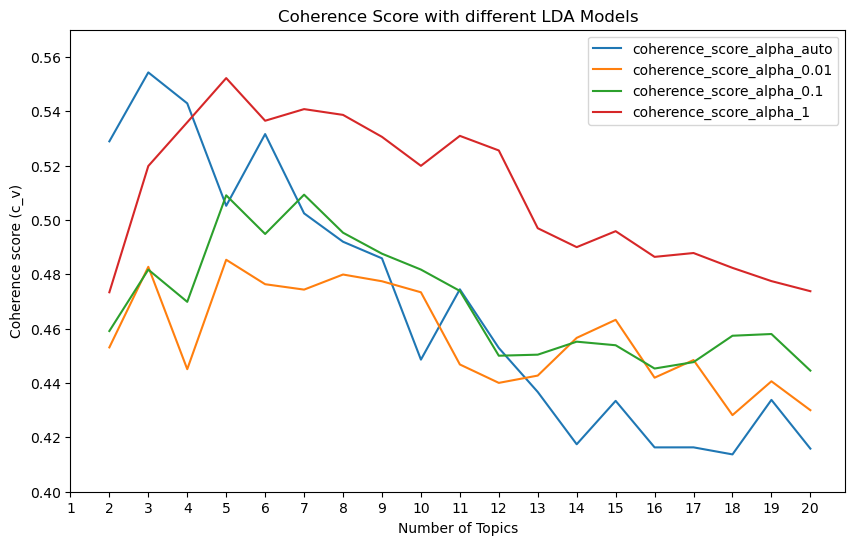

In [72]:
# Data
x = coherence_df['num_topics']
y_columns = ['coherence_score_alpha_auto', 'coherence_score_alpha_0.01', 'coherence_score_alpha_0.1', 'coherence_score_alpha_1']

# Plotting
plt.figure(figsize=(10, 6))  
for column in y_columns:
    plt.plot(x, coherence_df[column], label=column)

# Customize the plot
plt.title('Coherence Score with different LDA Models')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence score (c_v)')
plt.ylim([0.4, 0.57])
plt.xticks(range(1, 21))
plt.legend(loc='upper right')

# Show the plot
plt.show()

The line chart illustrates the coherence scores of various LDA models with different alpha values across a range of topics. Based on this graph, it is clear that LDA models with the alpha value of 1 get the best coherence scores.

In [73]:
# Function to plot coherence score
def plot_coherence(coherence_df, peak_height=0.5):
    plt.figure(figsize=(16,6))
    plt.plot(coherence_df.iloc[:,0], coherence_df.iloc[:,1], marker='o', linestyle='-')
    plt.xlabel('Numbers of Topics')
    plt.ylabel('Coherence score (c_v)')
    plt.title('Coherence Score - LDA Model Selection')
    plt.ylim([0.41, 0.6])
    plt.xticks(range(1, 21))
        
    # Find peaks
    peaks, _ = find_peaks(coherence_df.iloc[:,1], height=peak_height)  
    
    # Plot vertical lines at peak positions
    for peak in peaks:
        plt.axvline(x=coherence_df.iloc[peak, 0], color='r', linestyle='--', label='Peak')
        plt.annotate(f'Peak: {coherence_df.iloc[peak, 1]:.4f}',
                     (coherence_df.iloc[peak, 0], coherence_df.iloc[peak, 1]),
                     textcoords="offset points", xytext=(0, 10), ha='center')
   
    plt.show()

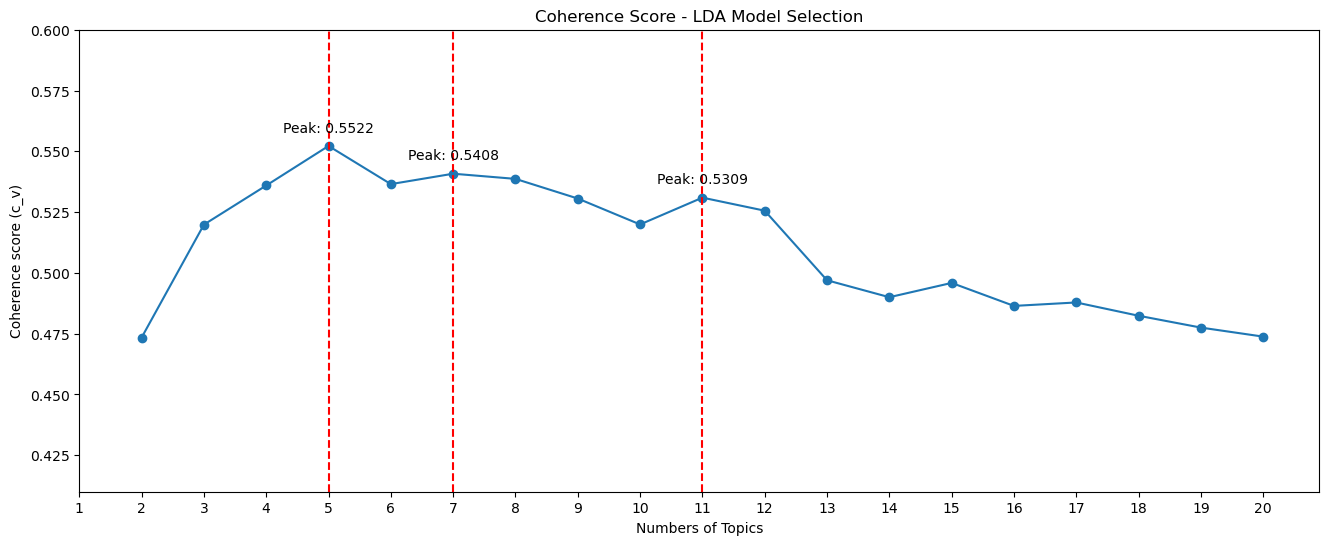

In [75]:
# Plot coherence score for LDA models with alpha = 1
plot_coherence(coherence_values_1)

The vertical red line marks the local maximum points of coherence scores, suggesting where the potential optimal models could be found. These peaks occur at 5, 7, and 11 topics, with the highest peak at 5 topics. As the higher coherence score indicates that the words in a topic are more related to each other, this means that the model with 5 topics has the most coherent and interpretable topics; therefore, is the most ideal candidate for final model selection.

However, the selection of the final model should not be based on coherence scores alone. It is crucial to conduct a qualitative review of the topics, which involves examining topic
visualizations and analyzing the most frequent words within each topic.

Based on the coherence score graph and the perplexity graph, the model with the best coherence had a number of topics set to 5. However, upon examining the perplexity graph, it is observed that the perplexity begins to decrease with a higher number of topics after 11. This suggests that while the model with 5 topics excels in coherence, it might not fully capture the underlying complexity of the data. Models with 7 or 11 topics appear to strike a better balance between coherence and perplexity, potentially providing more nuanced insights into the dataset's structure and content.

Further analysis and topic visualizations will help to determine which of these models is the most informative and best model.

In [78]:
# Load the saved LDA model
lda_model_5 = gensim.models.ldamodel.LdaModel.load("C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 1/lda_model_5_topics_alpha_1.model")
lda_model_7 = gensim.models.ldamodel.LdaModel.load("C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 1/lda_model_7_topics_alpha_1.model")
lda_model_11 = gensim.models.ldamodel.LdaModel.load("C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 1/lda_model_11_topics_alpha_1.model")

In [79]:
# visualize the model with 5 topics
pyLDAvis.gensim_models.prepare(lda_model_5, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.033929  0.302863       1        1  25.356439
3     -0.188205 -0.055671       2        1  23.380555
1     -0.109319  0.091999       3        1  21.673836
0     -0.088565 -0.299503       4        1  16.700032
4      0.420018 -0.039688       5        1  12.889138, topic_info=      Term          Freq         Total Category  logprob  loglift
101  great  66992.000000  66992.000000  Default  30.0000  30.0000
314   work  54696.000000  54696.000000  Default  29.0000  29.0000
1     good  62918.000000  62918.000000  Default  28.0000  28.0000
219  sound  60955.000000  60955.000000  Default  27.0000  27.0000
183  price  29153.000000  29153.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
40     buy  12960.503280  27942.634871   Topic5  -3.7159   1.2805
263   well  18177.181457  52208.887293   Topic5  -3.3776   0.9937
3     need   8792.311878  24047.241852   Topic5  -4.1039   1.0426
254  value   2930.499878   3829.096439   Topic5  -5.2026   1.7813
266  worth   3009.857237   5756.041313   Topic5  -5.1759   1.4004

[271 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1066      1  0.999849   acoustic
16        1  0.999729     action
17        2  0.806824        add
17        3  0.192973        add
1187      5  0.999666  advertise
...     ...       ...        ...
266       4  0.000521      worth
266       5  0.522929      worth
837       1  0.999667      wrong
12        1  0.923889       year
12        4  0.075941       year

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

In [80]:
# visualize the model with 7 topics
pyLDAvis.gensim_models.prepare(lda_model_7, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.146945 -0.009734       1        1  17.742920
6     -0.134124 -0.135753       2        1  17.618278
2     -0.106124 -0.046147       3        1  16.737677
1     -0.127088 -0.117549       4        1  15.892815
0      0.003634  0.086900       5        1  12.660979
4      0.085461  0.395327       6        1  10.286006
5      0.425186 -0.173043       7        1   9.061325, topic_info=            Term          Freq         Total Category  logprob  loglift
101        great  66327.000000  66327.000000  Default  30.0000  30.0000
1           good  61441.000000  61441.000000  Default  29.0000  29.0000
314         work  58701.000000  58701.000000  Default  28.0000  28.0000
263         well  52033.000000  52033.000000  Default  27.0000  27.0000
219        sound  55354.000000  55354.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1459   fantastic   1614.657145   2260.913583   Topic7  -5.4463   2.0645
105         high   3409.432525  11507.115316   Topic7  -4.6989   1.1847
454   definitely   2192.305386   5499.009734   Topic7  -5.1405   1.4815
191       really   3650.304926  24663.254267   Topic7  -4.6306   0.4907
1067     amazing   1807.369293   4348.883301   Topic7  -5.3335   1.5231

[338 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1066      3  0.999897   acoustic
17        1  0.814609        add
17        4  0.185213        add
994       6  0.999214   addition
1187      6  0.999681  advertise
...     ...       ...        ...
314       6  0.999982       work
266       2  0.999807      worth
12        2  0.999914       year
511       2  0.210094        yet
511       6  0.789572        yet

[428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 3, 2, 1, 5, 6])

In [81]:
# visualize the model with 11 topics
pyLDAvis.gensim_models.prepare(lda_model_11, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.177582  0.114344       1        1  10.957668
1     -0.216774  0.030259       2        1  10.951874
2     -0.149426  0.211301       3        1   9.861838
6      0.111880 -0.134295       4        1   9.804855
7      0.091447  0.094114       5        1   9.756355
10     0.195748  0.090951       6        1   9.101606
0      0.061135  0.000106       7        1   8.826281
3      0.015436  0.087352       8        1   8.315186
4     -0.230844  0.038083       9        1   8.269053
8      0.113264 -0.269898      10        1   7.594987
5     -0.169447 -0.262317      11        1   6.560296, topic_info=              Term          Freq         Total Category  logprob  loglift
101          great  64858.000000  64858.000000  Default  30.0000  30.0000
1             good  60080.000000  60080.000000  Default  29.0000  29.0000
314           work  56615.000000  56615.000000  Default  28.0000  28.0000
405            use  71362.000000  71362.000000  Default  27.0000  27.0000
263           well  50184.000000  50184.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
2114          dirt    242.771909    243.846807  Topic11  -7.0181   2.7197
805   consistently    240.010471    241.085458  Topic11  -7.0295   2.7197
308           look  16175.177576  27429.605531  Topic11  -2.8190   2.1960
1251        seller   1475.371649   1904.031618  Topic11  -5.2135   2.4691
254          value   2251.638868   4052.961562  Topic11  -4.7908   2.1363

[423 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
528       8  0.999340  accurate
1066      3  0.999848  acoustic
16        9  0.999432    action
409       2  0.999708  actually
17        1  0.342615       add
...     ...       ...       ...
2269     11  0.994533      worn
266       5  0.999837     worth
837       4  0.999805     wrong
12        6  0.999851      year
511       6  0.999730       yet

[453 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 3, 7, 8, 11, 1, 4, 5, 9, 6])

Upon carefully examing the intertopic distance maps for models with 5, 7, and 11 topics in Figure 25, some observations on the topic clusters are noted as follows:
- Model with 5 topics form clear distinct topic clusters with very little overlap. However, the clusters do not occupy a large portion of the surface. This raises the question that this model does may not fully capture the diversity of the data and oversimplify the underlying topics.
- Model with 7 topics has excessive overlaps between topic 1, 2, 3, and 4. Such overlaps are not ideal because topics could be too closely related, which could cause ambiguity when classify reviews into these topics.
- Model with 11 topics has some overlaps especially between topics 9 and 2, 1 and 6. While having overlaps is generally not preferred, it is less extensive than in the 7-topic model. Besides, the topic clusters are relatively equal in size and more evenly distributed across the surface. This may indicate a better representation of the data’s complexity and diversity.

Given these observations, the decision for the final LDA narrows down to the model with 5 or 11 topics.To make an informed decision, it is necessary to examine the words associated with
each topic in these models. The model with 5 topics offers a broader and simpler representation of the data, making it more interpretable at a high level. On the other hand, the 11-topic model gives a greater variety in the top words, indicating a more nuanced and specific topics. This granularity provides a more granular understanding of the dataset. This is be particularly useful to categorize documents into more precise topics. In addition, it also has the third-highest coherence. Therefore, after careful deliberation, the most suitable choice for the final LDA model is one with 11 topics as it can provide more insights from the data.

## 3. Select the final LDA model

The final LDA model selected has 11 topics with an alpha value of 1.

In [35]:
final_lda_model = gensim.models.ldamodel.LdaModel.load("C:/Users/QuynhDinhHaiPham/Desktop/2. Python Code/Saved Models/LDA/Alpha 1/lda_model_11_topics_alpha_1.model")

In [36]:
pprint.pprint(final_lda_model.print_topics())
final_doc_lda = final_lda_model[corpus]

[(0,
  '0.039*"small" + 0.038*"light" + 0.031*"stand" + 0.029*"enough" + '
  '0.028*"hold" + 0.028*"keep" + 0.025*"size" + 0.025*"build" + 0.020*"bag" + '
  '0.020*"solid"'),
 (1,
  '0.089*"get" + 0.043*"little" + 0.030*"thing" + 0.026*"way" + 0.026*"bit" + '
  '0.024*"take" + 0.022*"pretty" + 0.021*"want" + 0.019*"right" + '
  '0.016*"star"'),
 (2,
  '0.125*"sound" + 0.081*"pedal" + 0.033*"tone" + 0.027*"really" + '
  '0.020*"pickup" + 0.019*"effect" + 0.016*"volume" + 0.016*"knob" + '
  '0.015*"clean" + 0.014*"color"'),
 (3,
  '0.092*"string" + 0.054*"set" + 0.041*"high" + 0.041*"bass" + 0.038*"case" + '
  '0.035*"end" + 0.035*"low" + 0.030*"lot" + 0.020*"replace" + 0.019*"change"'),
 (4,
  '0.106*"guitar" + 0.087*"nice" + 0.065*"play" + 0.057*"strap" + 0.046*"easy" '
  '+ 0.031*"neck" + 0.025*"tuner" + 0.025*"instrument" + 0.024*"fret" + '
  '0.024*"tune"'),
 (5,
  '0.239*"great" + 0.222*"good" + 0.104*"price" + 0.096*"quality" + '
  '0.065*"product" + 0.060*"look" + 0.056*"love" + 

It's important to calculate the size of each topic as a percentage of the total tokens in the corpus. This calculation provides insights into the distribution and importance of topics within the dataset. 

In [39]:
# Function to calculate the size of each topic as a percentage of total tokens
def topic_sizes(lda_model, corpus):
    topic_weights = [0] * lda_model.num_topics
    total_tokens = 0

    for doc in corpus:
        doc_total_tokens = sum(freq for _, freq in doc)
        total_tokens += doc_total_tokens
        for index, score in lda_model.get_document_topics(doc, minimum_probability=0):
            weighted_score = score * doc_total_tokens
            topic_weights[index] += weighted_score

    topic_percentages = [(i, weight / total_tokens * 100) for i, weight in enumerate(topic_weights)]
    return topic_percentages

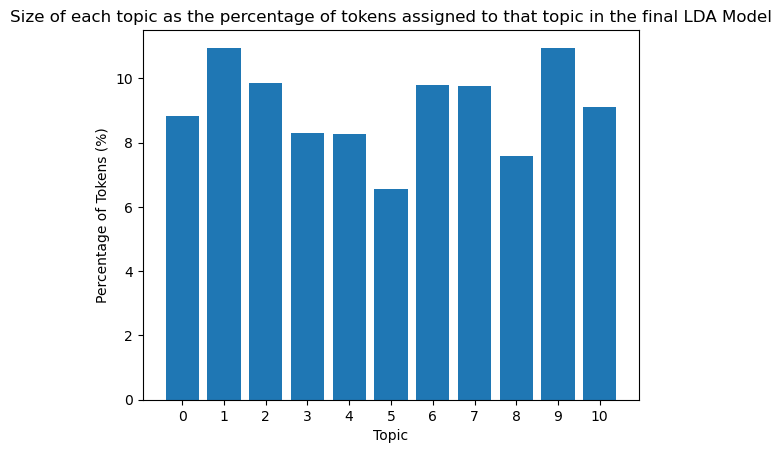

In [40]:
# Calculate topic sizes
topic_percentages = topic_sizes(final_lda_model, corpus)

# Plotting
topics, percentages = zip(*topic_percentages)
plt.bar(topics, percentages)
plt.xlabel('Topic')
plt.ylabel('Percentage of Tokens (%)')
plt.title('Size of each topic as the percentage of tokens assigned to that topic in the final LDA Model')
plt.xticks(range(len(topics)))
plt.show()

# VI. Futher Analysis for Deeper Insights into Customer Feedback

Selecting the final LDA model and identifying the topics it uncovers is a crucial step, but it's only the beginning. The real value lies in turning these topics into business insights. To do this, further analysis is essential. With LDA, each review is made up of distributions of many topics. However, to simplifying the analysi, each review is assigned to the single most probable topic. This approach makes it easier to handle the data and allows for different types of analysis based on the business needs and requirements. 

Examples of some key questions that can be answered with additional analytics include:
1. Which topics do customers talk about most and least in their reviews?
2. What topics are becoming more or less popular over time?
3. Which topics are linked to the highest and lowest customer ratings, and which products are connected to these topics?
4. For any given product, what topics are customers discussing the most?

In [41]:
# Function to find the most probable topic for each document
def assign_topics_to_documents(lda_model, corpus):
    doc_topics = []
    for doc_bow in corpus:
        # Get the topic distribution for the document
        topic_distribution = lda_model.get_document_topics(doc_bow)
        
        # Sort the topics by probability
        topic_distribution.sort(key=lambda x: x[1], reverse=True)
        
        # Get the most probable topic
        most_probable_topic = topic_distribution[0][0]
        doc_topics.append(most_probable_topic)
    
    return doc_topics

In [42]:
# Assign topics to each document
document_topics = assign_topics_to_documents(final_lda_model, corpus)

# Example: print the topic for the first 5 documents
for i in range(5):
    print(f"Review {i+1} is most likely about topic {document_topics[i]}")

Review 1 is most likely about topic 5
Review 2 is most likely about topic 4
Review 3 is most likely about topic 10
Review 4 is most likely about topic 4
Review 5 is most likely about topic 6


In [43]:
# Add column Topic to the dataframe. Each review will be assigned to 1 probable topic.
df['Topic'] = document_topics
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,language,ReviewDate,Topic
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN,en,2016-10-30,5
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN,en,2016-06-30,4
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN,en,2016-05-09,10
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN,en,2016-04-10,4
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN,en,2016-02-06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231387,5.0,True,"03 29, 2018",A2GLR2Q3M1PC7P,B01HIDOPP2,nic field,It's pretty great.,Five Stars,1522281600,NaN,NaN,NaN,en,2018-03-29,5
231388,5.0,True,"11 18, 2017",A3S1LSTRW57BP9,B01HIDOPP2,2gene,Good inexpensive wiring harness. It will do th...,Five Stars,1510963200,NaN,NaN,NaN,en,2017-11-18,4
231389,4.0,True,"06 5, 2017",A2BNWRRADDBSVO,B01HIDOPP2,Tim,Easily installed and worked as expected.,Four Stars,1496620800,NaN,NaN,NaN,en,2017-06-05,8
231390,1.0,True,"05 27, 2017",A1KRL5ZRON6DPT,B01HIDOPP2,Jude the Obscure,The description stated they were full size pot...,Not as described.,1495843200,NaN,NaN,NaN,en,2017-05-27,2


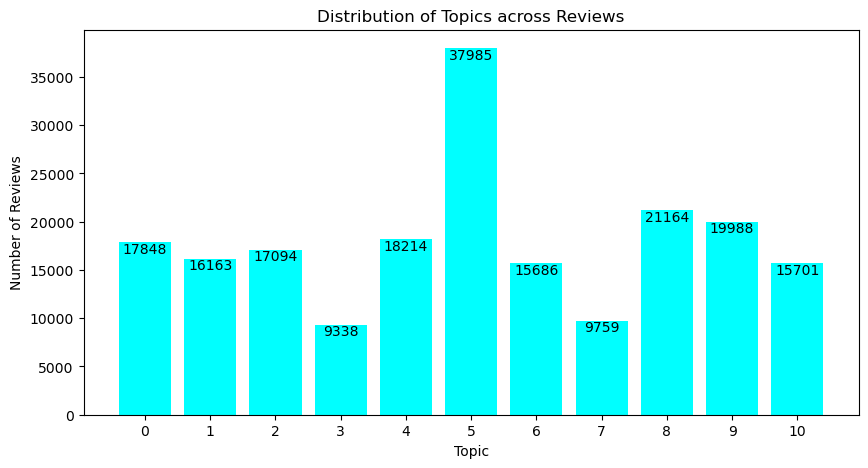

In [93]:
# Count the occurrence of each topic
topic_counts = df['Topic'].value_counts()

# Plotting
topics, counts = zip(*topic_counts.items())
plt.figure(figsize=(10, 5))
bars = plt.bar(topics, counts, color='cyan')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, va='top', ha='center')
    
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Topics across Reviews')
plt.xticks(topics)
plt.show()

Regarding the most discussed topics, it appears that topic 5 is the most discussed among all users with 37,985 reviews. A detailed look at this topic reveals keywords like "great", "good", "price", "quality", "product", "look", "love", "awesome", "deal" and "fast". These terms suggests that topic might revolve around topic "Value for Money". While words like "price", "quality", "product", "deal" might relate to monetary aspect, other words like "great", "good", "love", "awesome" are indicative of positive customer experience and satisfaction. In contrast, Topics 3 and 7 exhibit the least engagement, with 9,338 and 9,759 reviews respectively. These topics may either represent a niche area of interest within the dataset or not well captured the hidden themes in the model development process.

From these observations, some suggestions can be drawn:
- Businesses should further go through the content written in reviews associated with topic 5 to pinpoint what drives customer satisfaction. An additional sentiment analysis in this topic might help understand the nuances of customer feedback, including positive, neutral, and negative sentiments.
- The low discussion around topic 3 and topic 7 presents an opportunity for business to increase focus in these areas. This could involve offering additional information or improved product offerings that could increase customer engagement and satisfaction in these areas.

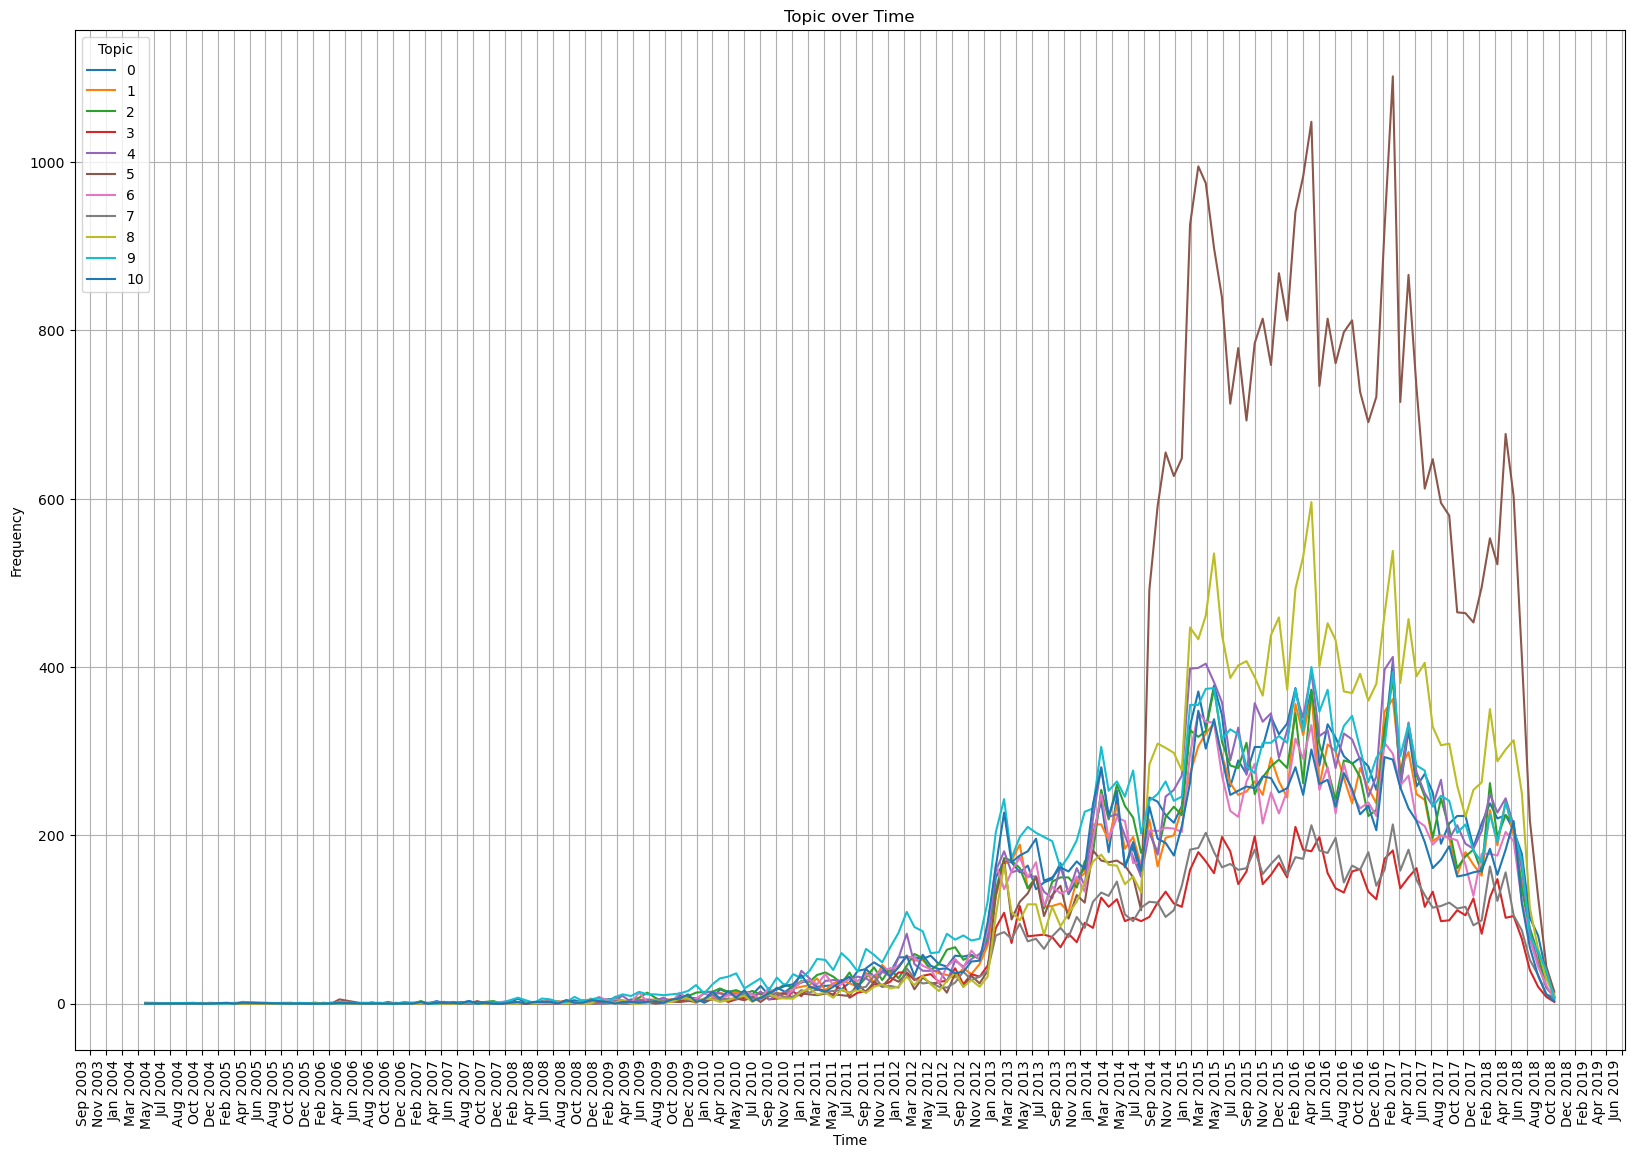

In [60]:
# Resample the data to monthly frequency and count the occurrences
topic_time_counts = df.set_index('ReviewDate').resample('M')['Topic'].value_counts().unstack(fill_value=0)

# Plot the frequency of topics over time
fig, ax = plt.subplots(figsize=(20, 15))  # Increase figure size
topic_time_counts.plot(kind='line', ax=ax)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Topic over Time')
plt.legend(title='Topic', loc='upper left')
plt.grid()

# Set x-axis formatter for displaying dates in 'Month Year' format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Set x-axis locator to ensure a consistent number of ticks (adjust the number based on your data range)
ax.xaxis.set_major_locator(plt.MaxNLocator(100))  # Adjust to show an appropriate number of ticks

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

To understand how customer interests and market trends shift over time, it is helpful to look at topic trends over time. Normally, some topics might become less relevant as others gain
traction. 

According to the data exploration phase, most of the dataset covers the years 2013 to 2017, which aligns with the observed fluctuations in topic popularity as presented in Figure 28.
In general, every topic sees some level of increased attention over the years. However, period from July 2014 to June 2018 saw particularly pronounced spikes in topic 5 and topic 8 in their frequency of discussion. These sudden increases could be linked to major events or shifts within the music industry, which will require expert knowledge to fully assess. For instance, there might be breakthroughs in musical technology or influential endorsements of particular instruments or accessories during this period that spurred interest in these topics. Additionally, broader economic trends, like increased disposable income or the introduction of cost-effective product lines, could have contributed to the rise in these discussions. For business, understand these fluctuations is beneficial to investigate the underlying causes of the heightened interest in Topics 5 and 8 as this can drive decision to make adjustments in product development, marketing strategies, or customer engagement.

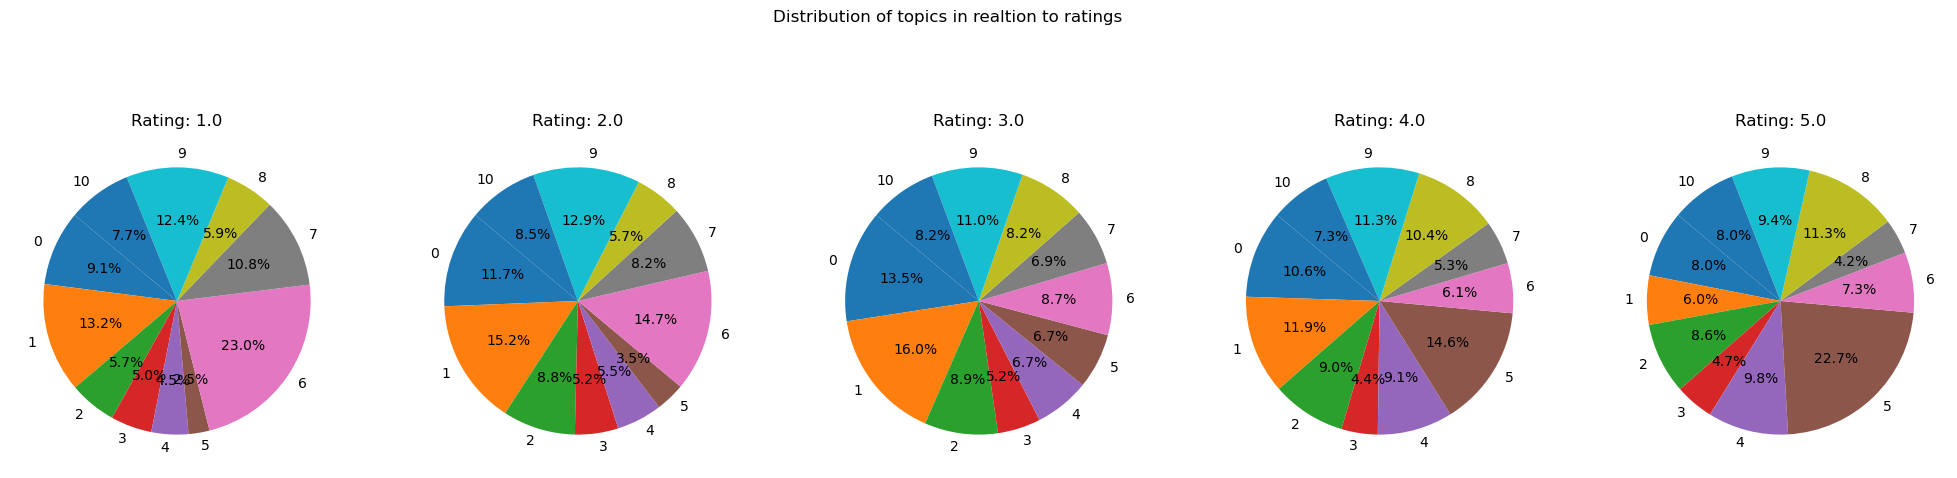

In [95]:
# Count the occurrences of each topic within each rating
rating_topic_counts = df.groupby(['overall', 'Topic']).size().unstack(fill_value=0)

# Number of pie charts will be equal to the number of unique ratings
n_ratings = len(rating_topic_counts)

# Create a figure with multiple axes to plot each pie chart
fig, axes = plt.subplots(1, n_ratings, figsize=(n_ratings * 5, 6))  # Adjust figsize as needed

# Plot a pie chart for each rating
for i, (rating, counts) in enumerate(rating_topic_counts.iterrows()):
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Rating: {rating}')

plt.suptitle('Distribution of topics in realtion to ratings')
plt.show()

To delve deeper, we can examine how different topics are represented across various rating levels. 

At first glance, it's evident that topic 5 makes up a significant portion of the reviews in the higher rating categories (4.0 and 5.0). This may indicate that customers who believe they are getting good value for their money tend to give higher ratings. It might also a reflection of company’s successful pricing strategies and product quality that meet customer expectations. To identify the products that align with this positive perception, looking at the five leading products that consistently receive high ratings in conjunction with Topic 5. These products are: B0006LOBA8, B0002E3CK4, B0002H05BA, B0002H03YY, B0007Y09VO (as shown by the code below).

On the other side of the spectrum, Topic 6 is more frequently mentioned in reviews with lower ratings (1.0 and 2.0). The prominence of this topic highlights the areas that may require attention from businesses, such as customer service, purchasing processes, or product expectations. Addressing the issues associated with topic 6 could potentially improve customer satisfaction and lead to an improvement in ratings. The products most commonly associated with Topic 6, and thus receiving lower ratings, are: B0017H4EBG, B0027V760M, B0002GMH7G,
B0002GMGYA, B00AZUAORE (as shown in the code below).

In [47]:
def get_top_products(df, top_n, topic_number, rating):
    """
    Returns the top n products for a given topic and rating.

    :param df: DataFrame containing the data.
    :param top_n: Number of top products to return.
    :param topic_number: The topic number to filter by.
    :param rating: The rating to filter by.
    :return: A Series containing the top n products.
    """
    # Filter for the specified topic
    topic_df = df[df['Topic'] == topic_number]

    # Further filter for the specified rating within the topic
    filtered_df = topic_df[topic_df['overall'] == rating]

    # Group by 'asin' (Product ID), count the occurrences, and sort in descending order
    top_products = filtered_df['asin'].value_counts().sort_values(ascending=False).head(top_n)
    
    # Display the top n Product IDs for the specified topic and rating
    print(f"Top {top_n} Products in Topic {topic_number} with Rating {rating}:", top_products)

    return top_products

In [48]:
# Get the top 5 products in Topic 5 (Value for Money) with a Rating of 5
top_products = get_top_products(df, 5, 5, 5) 

Top 5 Products in Topic 5 with Rating 5: asin
B0006LOBA8    395
B0002E3CK4    395
B0002H03YY    395
B0002H05BA    395
B0002H0A3S    286
Name: count, dtype: int64


In [50]:
# Get the top 5 products in Topic 6 with a Rating of 1
top_products = get_top_products(df, 5, 6, 1) 

Top 5 Products in Topic 6 with Rating 1: asin
B0017H4EBG    9
B0027V760M    9
B0002GMH7G    8
B0002GMGYA    8
B00AZUAORE    7
Name: count, dtype: int64


For detailed insights on any specific product, the distribution on topics for that product can be identified, as shown below. By examining the actual content of the reviews, deeper
questions can be addressed. For example, are there specific features or benefits that are consistently highlighted? Alternatively, are there persistent issues or shortcomings that are frequently brought up? This type of in-depth analysis could be incredibly useful for product managers, marketing teams, and customer service team.

In [49]:
# Filter the DataFrame for the specific product ID, count the number of reviews per topic, and plot the frequency.
#   :param product_id: The product ID to filter by.
#   :param df: DataFrame containing the data.
#   :param bar_color: color for the bar chart, default is peachpuff color

def plot_reviews_by_topic(product_id, df, bar_color='peachpuff'):
    # Filter the DataFrame for the specific product ID
    product_reviews = df[df['asin'] == product_id]

    # Count the number of reviews per topic
    topic_counts = Counter(product_reviews['Topic'])

    # Sort topics by count in descending order
    sorted_topic_counts = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))

    # Extract topics and corresponding counts
    topics = list(sorted_topic_counts.keys())
    counts = list(sorted_topic_counts.values())

    # Convert topics to string for categorical labels
    topics_str = [str(topic) for topic in topics]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(topics_str, counts, color=bar_color)
    plt.xlabel('Topic')
    plt.ylabel('Number of Reviews')
    plt.title(f'Product {product_id}: Number of Reviews by Topic (Sorted Descending)')

    plt.xticks(ticks=range(len(topics_str)), labels=topics_str)

    plt.show()

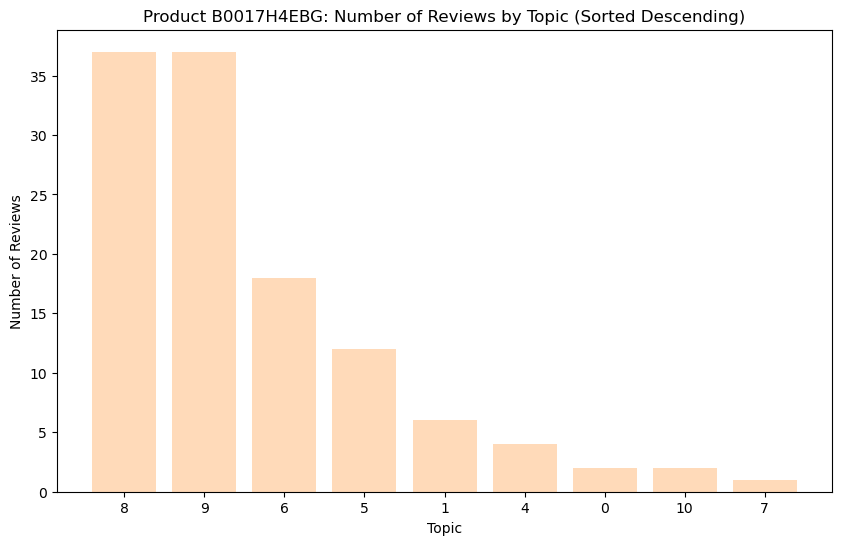

In [56]:
plot_reviews_by_topic('B0017H4EBG', df)

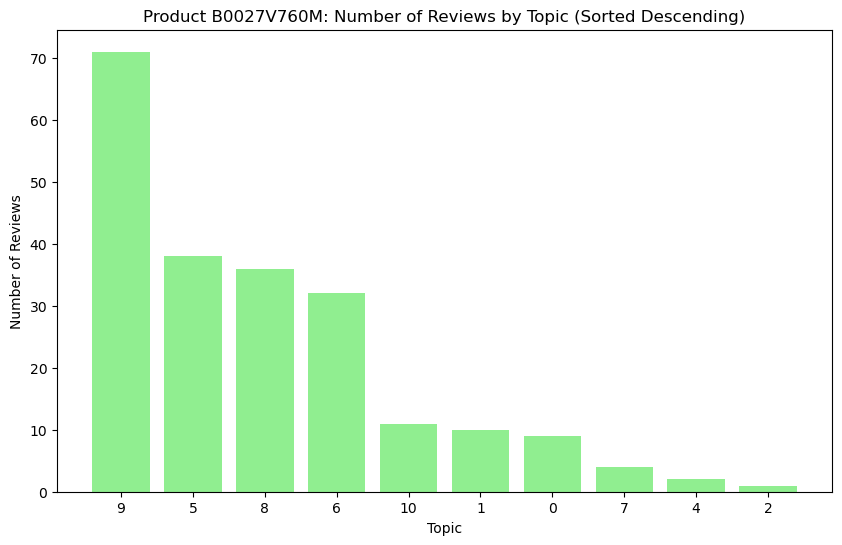

In [57]:
plot_reviews_by_topic('B0027V760M', df, bar_color='lightgreen')